# download data for cloud

In [1]:
from download_file import *

In [2]:
url = "https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip"
download_dir = 'data'
maybe_download_and_extract(url, download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


# importing some useful packages

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import cv2
import time as time
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

In [8]:
from keras.optimizers import Adam
from keras import losses, metrics

In [9]:
print (os.path.abspath(keras.__file__))
print (os.path.abspath(tf.__file__))

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/__init__.py
/home/carnd/anaconda3/lib/python3.5/site-packages/tensorflow/__init__.py


# Read data

In [10]:
def OHE_labels(Y_tr,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
    return Y_labels

In [11]:
def read_data_sets(file):
    """
    Load pickled data
    args:
        file   (str)     path to datasets 
    yields:
        features and label of datasets (numpy array)
    """
    with open(file, mode='rb') as f:
        return pickle.load(f)

In [12]:
# Load pickled data
import pickle

data_rel_path = "data"
#"aug_train_600"

train = read_data_sets(os.path.join(data_rel_path, "shuffle_aug_train.p"))
valid= read_data_sets(os.path.join(data_rel_path, "shuffle_aug_valid.p")) 
test = read_data_sets(os.path.join(data_rel_path, "shuffle_aug_test.p")) 

    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid, y_valid = valid['features'], valid['labels']
labels_train = OHE_labels(y_train,43)
labels_test = OHE_labels(y_test,43)
labels_valid = OHE_labels(y_valid,43)

In [13]:
def check_OHE(cls,y):
    check = np.linalg.norm(np.argmax(cls,axis=1)-y)
    if check == 0:
        print('One hot encoding correct, ok to proceed')
    else:
        print('One hot encoding doesnt match the output, check code!!!')

In [14]:
data_pd = pd.read_csv(os.path.join(data_rel_path, 'signnames.csv'))

In [15]:
check_OHE(labels_test,y_test)
check_OHE(labels_train,y_train)

One hot encoding correct, ok to proceed
One hot encoding correct, ok to proceed


# Dataset Exploration

## Dataset Summary

In [16]:
n_train = len(y_train)
n_test = len(y_test)
image_shape = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", len(y_valid))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 117863
Number of testing examples = 9822
Number of validation examples = 3274
Image data shape = (32, 32, 3)
Number of classes = 43


## Exploratory Visualization

In [17]:
def plot_random_3C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()
def plot_random_1C(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot],cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()   
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(pre_process_image(X[ind_plot]),cmap='gray')
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

### original images

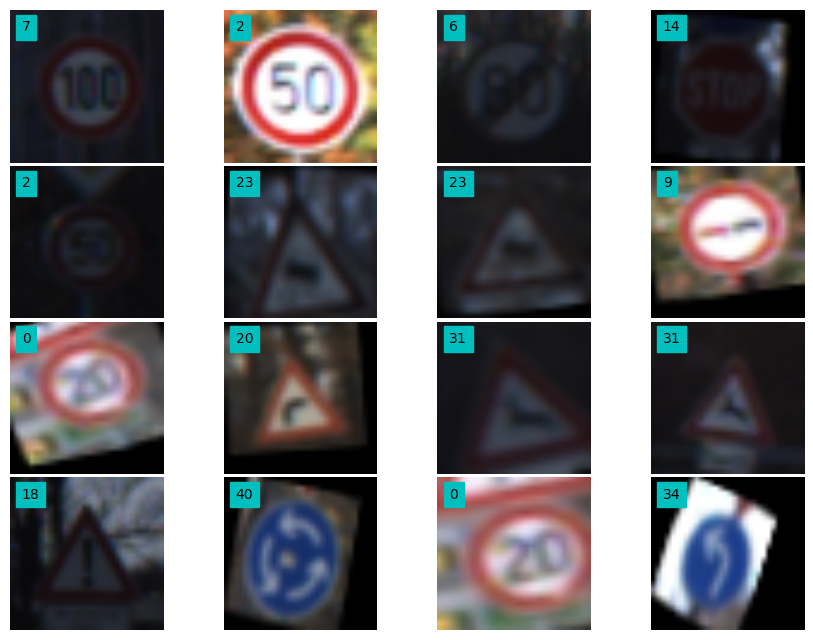

In [31]:
plot_random_3C(4,4,X_train,y_train)

### images after equalization 

In [18]:
def pre_process_image(image):

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    #image = image[:,:,0]
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    #image = cv2.resize(image, (img_resize,img_resize),interpolation = cv2.INTER_CUBIC)
    return image

In [15]:
img_resize = 32
N_classes = 43
image_shape = (img_resize,img_resize)
img_size_flat = img_resize*img_resize

image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

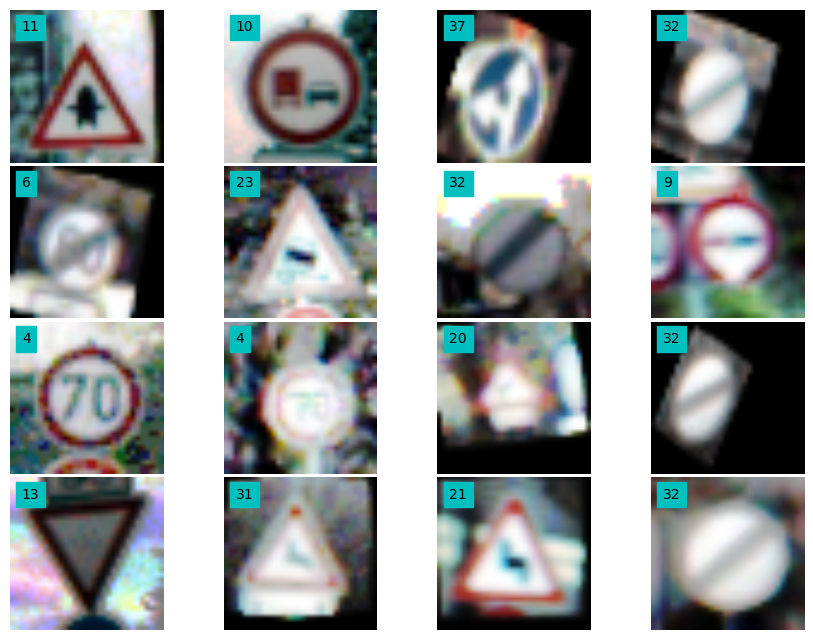

In [16]:
plot_random_3C(4,4,image_GS_train+.5,y_train)

### frequency table of training set

In [17]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [18]:
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0])
data_pd_sorted = data_pd_sorted.reindex(data_pd_sorted["ClassId"])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0])
data_pd_sorted = data_pd_sorted.drop(['ClassId'], axis = 1)

In [19]:
data_pd_sorted.head(10)

,SignName,Occurance
18,General caution,2779
28,Children crossing,2779
11,Right-of-way at the next intersection,2776
7,Speed limit (100km/h),2775
12,Priority road,2773
34,Turn left ahead,2769
25,Road work,2769
14,Stop,2766
38,Keep right,2765
42,End of no passing by vehicles over 3.5 metric ...,2764


In [20]:
data_pd_sorted.tail(10)

,SignName,Occurance
30,Beware of ice/snow,2729
1,Speed limit (30km/h),2728
22,Bumpy road,2722
2,Speed limit (50km/h),2721
0,Speed limit (20km/h),2685
27,Pedestrians,2682
37,Go straight or left,2664
41,End of no passing,2651
32,End of all speed and passing limits,2651
19,Dangerous curve to the left,2648


<Container object of 43 artists>

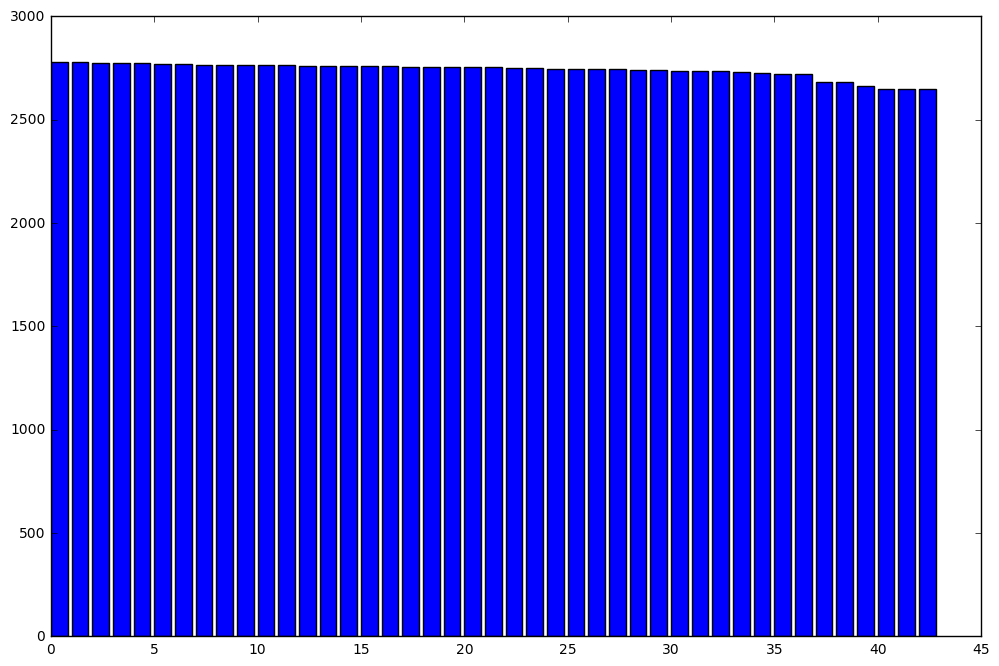

In [21]:
plt.figure(figsize=(12,8))
plt.bar(range(43),height=data_pd_sorted["Occurance"])

# Design and Test a Model Architecture

## Preprocessing

### histogram equalization: 
* reason: The contrast of brightness will be enhanced. Therefore the features will stand out.

In [19]:
img_size = 30

In [20]:
def show3img(img, img1, img2):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.title("Augmented image")
    plt.show()
    
def eq_Hist(img):
    #Histogram Equalization
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img):
    img2=sharpen_img(img)
    img2=crop(img2,3)
    img2=contr_img(img2, 1.5)
    return eq_Hist(img2)

def augment_img(img):
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img)

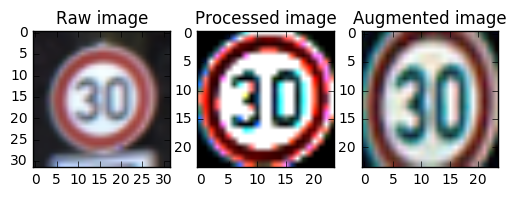

Final image size is (24, 24, 3)


In [21]:
x_selected = X_train[y_train == 1]
im=x_selected[100, :, :, :]
imp=contr_img(im, 0.5)

show3img(im, transform_img(im), augment_img(im))
print("Final image size is", transform_img(im).shape)

In [22]:
X_train_equalize = list()
X_test_equalize = list()
X_valid_equalize = list()

for i in range(len(X_train)):
    X_train_equalize.append(transform_img(X_train[i]))
for i in range(len(X_test)):
    X_test_equalize.append(transform_img(X_test[i]))    
for i in range(len(X_valid)):
    X_valid_equalize.append(transform_img(X_valid[i]))

In [23]:
X_train_equalize = np.array(X_train_equalize)
X_test_equalize = np.array(X_test_equalize)
X_valid_equalize = np.array(X_valid_equalize)

### normalization: 
* reason: improve learninig speed
* method: scaled images between -.5 and .5, by dividing by 255. and subtracting .5.

In [24]:
X_train_norm = X_train_equalize/255.
X_test_norm = X_test_equalize/255.
X_valid_norm = X_valid_equalize/255.

In [25]:
print (X_train_norm.shape)
print (X_test_norm.shape) 
print (X_valid_norm.shape) 

(117863, 24, 24, 3)
(9822, 24, 24, 3)
(3274, 24, 24, 3)


### data augmentation: 

* Because of limited data and the class imbalance, additional data was generated by affine transformation including 
    1. **rotation** with random number generated between +/- 40 degress
    2. **translation** by +/- 10 pixels along vertical and horizontal direction
    3. **shearing**

In [78]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(X_train_norm)

## Model

### Model Architechture

In [21]:
reg_weight_decay = np.power(10, -4* np.random.rand(10))
reg_weight_decay

array([2.62882194e-03, 2.59664763e-03, 3.21833998e-04, 5.70481295e-04,
       9.01558736e-03, 2.25526518e-04, 1.87182590e-02, 3.02278792e-02,
       1.89623192e-04, 5.96967127e-01])

In [26]:
def create_model(baseMapNum = 32, weight_decay = 1e-4, num_classes = 43):    
    model = Sequential()
    # 1: convolution
    model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train_norm.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#     model.add(Dropout(0.2))

    # 3: convolution
    model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#     model.add(Dropout(0.2))
    
    # 3: convolution
    model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [27]:
model1 = create_model(baseMapNum = 32, weight_decay = 1e-4, num_classes = 43)

In [28]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
__________

### Adam

In [29]:
opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.000001)
model1.compile(loss=losses.categorical_crossentropy,
              optimizer=opt_adam,
              metrics=["accuracy"])

In [30]:
model1.fit(X_train_norm, labels_train,
          batch_size=64,
          epochs=30,
          validation_data=(X_test_norm, labels_test),
          verbose=1,
          shuffle=True)    

Train on 117863 samples, validate on 9822 samples
Epoch 1/30
117863/117863 [==============================] - 44s 376us/step - loss: 1.2342 - acc: 0.6321 - val_loss: 0.4473 - val_acc: 0.8677
Epoch 2/30
117863/117863 [==============================] - 43s 367us/step - loss: 0.4774 - acc: 0.8642 - val_loss: 0.2632 - val_acc: 0.9311
Epoch 3/30
117863/117863 [==============================] - 43s 367us/step - loss: 0.3502 - acc: 0.9059 - val_loss: 0.2633 - val_acc: 0.9358
Epoch 4/30
117863/117863 [==============================] - 43s 368us/step - loss: 0.2951 - acc: 0.9257 - val_loss: 0.2776 - val_acc: 0.9338
Epoch 5/30
117863/117863 [==============================] - 43s 367us/step - loss: 0.2678 - acc: 0.9360 - val_loss: 0.2104 - val_acc: 0.9564
Epoch 6/30
117863/117863 [==============================] - 43s 366us/step - loss: 0.2478 - acc: 0.9438 - val_loss: 0.1895 - val_acc: 0.9630
Epoch 7/30
117863/117863 [==============================] - 43s 365us/step - loss: 0.2361 - acc: 0.9490 

In [31]:
model1.save_weights('model//shuffle.h5')

In [32]:
scores = model1.evaluate(X_valid_norm, labels_valid, batch_size=64, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

3274/3274 [==============================] - 0s 137us/step

Test result: 97.373 loss: 0.174


# continue training

In [70]:
def create_model_2(baseMapNum = 32, weight_decay = 1e-4, num_classes = 43):    
    model = Sequential()
    # 1: convolution
    model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train_norm.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.35))

    # 3: convolution
    model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    # 3: convolution
    model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # 2: maxpool
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    model.add(Dense(256))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [71]:
from keras.models import load_model
# load_weights only sets the weights of your network. You still need to define its architecture before calling load_weights

In [72]:
model2 = create_model_2(weight_decay = 1e-4)

In [73]:
model2.load_weights('model//keras_german_sign_ADAM_weighted_Decay_VGG_000001.h5')

In [ ]:
opt_adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0000001)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics=['accuracy'])

In [ ]:
model2.fit(X_train_norm, labels_train,
          batch_size=64,
          epochs=30,
          validation_data=(X_test_norm, labels_test),
          verbose=1,
          shuffle=True)    

Train on 67389 samples, validate on 12630 samples
Epoch 1/30
67328/67389 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9620